In [1]:
import re #module to work with regular expressions
from difflib import SequenceMatcher

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix #scipy is a library for scientific computing and technical computing 
from sklearn.neighbors import NearestNeighbors #for KNearestNeighbor Algorithm 


IMPORTING THE DATA SET

In [2]:
movies=pd.read_csv("movies.csv")
movies=movies.drop(['genres'],axis='columns')

In [3]:
ratings=pd.read_csv("ratings.csv")
ratings=ratings.drop(['timestamp'],axis='columns')


In [4]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
ratings['rating'].sort_values().unique()

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

Number of Movies

In [7]:
movies.values.shape[0]

9742

Total number of ratings

In [8]:
ratings.values.shape[0]

100836

Number of Unique Users

In [9]:
ratings['userId'].nunique()

610

The Long Tail property : 
A general trend observed in statistics and buisness is that a small percentage of entities are highly polpular and rest are not as popular

SETTING THE THRESHOLD VALUES FOR POPULAR MOVIES

In [10]:
popular_movies_thresh=25
active_users_thresh=100

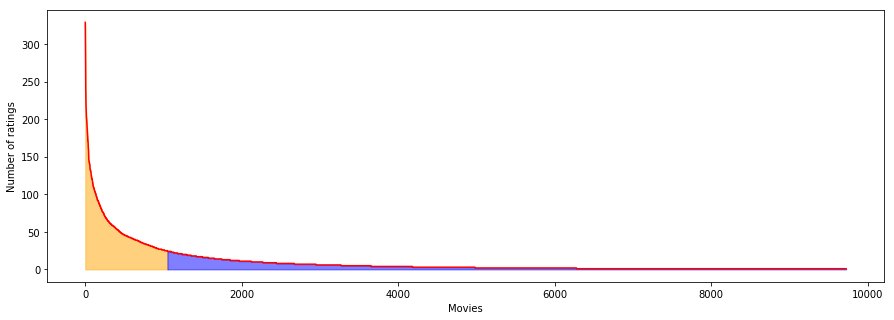

In [11]:
movies_count=pd.DataFrame(ratings.groupby('movieId').size().sort_values(ascending=False),columns=['count'])
divider=len(movies_count.query('count>=@popular_movies_thresh'))
fig,(ax)=plt.subplots(1,1,figsize=(15,5))
plt.plot(np.arange(len(movies_count)),movies_count['count'],color='red')
plt.xlabel('Movies')
plt.ylabel('Number of ratings')

ax.fill_between(np.arange(0,divider),0,movies_count['count'][:divider],
               color='orange',
               alpha=0.5)

ax.fill_between(np.arange(divider,len(movies_count)),
                0,
                movies_count['count'][divider:],
               color='blue',
               alpha=0.5)


In [12]:
movies_count

,count
movieId,
356,329
318,317
296,307
593,279
2571,278
260,251
480,238
110,237
589,224


Removing Unpopular Items

In [13]:
popular_movies_indices=movies_count.query('count>=@popular_movies_thresh').index
popular_rating=ratings[ratings['movieId'].isin(popular_movies_indices)]

In [14]:
ratings.shape[0] #Number of rows of movies

100836

In [15]:
popular_rating.shape[0] #decrease by 40 percent 

62518

In [16]:
ratings.groupby('movieId').count().shape[0] #number of movies before dropping unpopular movies

9724

In [17]:
popular_rating.groupby('movieId').count().shape[0] #number of movies after dropping unpopular movies

1050

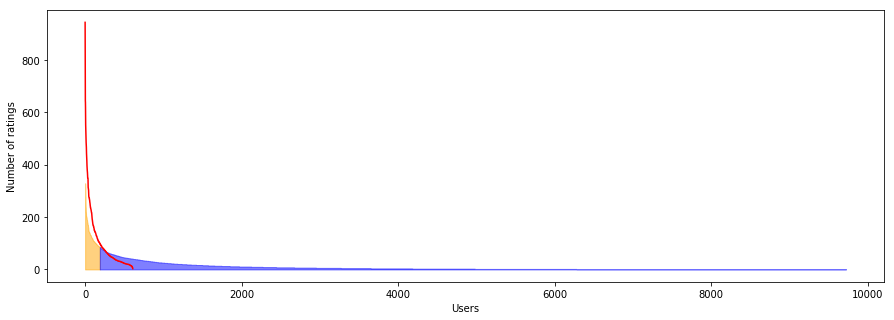

In [18]:
user_count=pd.DataFrame(popular_rating.groupby('userId').size().sort_values(ascending=False),columns=['count'])
divider=len(user_count.query('count>=@active_users_thresh'))
fig,(ax)=plt.subplots(1,1,figsize=(15,5))
plt.plot(np.arange(len(user_count)),user_count['count'],color='red')
plt.xlabel('Users')
plt.ylabel('Number of ratings')

ax.fill_between(np.arange(0,divider),0,movies_count['count'][:divider],
               color='orange',
               alpha=0.5)

ax.fill_between(np.arange(divider,len(movies_count)),
                0,
                movies_count['count'][divider:],
               color='blue',
               alpha=0.5)

In [19]:
active_users_indicies=user_count.query('count>=@active_users_thresh').index
active_users_ratings=popular_rating[popular_rating['userId'].isin(active_users_indicies)]

In [20]:
active_users_ratings.groupby('userId').count().shape[0]

188

In [21]:
pivot_table=active_users_ratings.pivot(index='movieId',columns='userId',values='rating').fillna(0)

If we use the above table the speed will be slow so we use a sparse matrix

In [22]:
sparse_matrix=csr_matrix(pivot_table.values)

Now we will perform mapping of 
movie title -> movie id
and
movie id -> movie title

In [23]:
pivot_table_movies=movies.set_index('movieId').loc[pivot_table.index]['title'].values
title_to_id={movie:i for i,movie in enumerate(pivot_table_movies)}

In [24]:
id_to_title={v:k for k,v in title_to_id.items()}

In [30]:
model_knn=NearestNeighbors(metric='cosine',algorithm='brute')
model_knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [32]:
def find_matches(title_to_id,movie_title):
    movie_ids=np.array(list(title_to_id.values())).astype(int)
    titles=np.array(list(title_to_id.keys()))
    ratios=list()
    for title,movie_id in title_to_id.items():
        ratio=SequenceMatcher(None,movie_title,title,autojunk=False).ratio()
        ratios.append(ratio)
    title,ids=titles[np.argsort(ratios)][-10:],movie_ids[np.argsort(ratios)][-10:]
    return list(reversed(list(zip(title,ids))))

In [34]:
title='batman'
options=find_matches(title_to_id,title)

import ipywidgets as widgets
drop=widgets.Dropdown(options=options)
drop

Dropdown(options=(('Batman (1989)', 155), ('Batman Begins (2005)', 860), ('Watchmen (2009)', 941), ('Batman & …

In [38]:
movie_id=drop.value
test=pivot_table.iloc[movie_id,:].values.reshape(1,-1)
distances,indices=model_knn.kneighbors(test,n_neighbors=10+1)
indices=indices.squeeze()[1:]

print('Reccomendation for :', id_to_title[movie_id])
for i,index in enumerate(indices):
    print(i+1,'.',id_to_title[index])

Reccomendation for : Batman Returns (1992)
1 . Batman & Robin (1997)
2 . Batman Forever (1995)
3 . Batman (1989)
4 . RoboCop (1987)
5 . Die Hard 2 (1990)
6 . Die Hard (1988)
7 . Highlander (1986)
8 . Mummy, The (1999)
9 . Con Air (1997)
10 . Superman (1978)
